## Libraries

In [1]:
import numpy as np  
import pandas as pd 
import os  
import cv2 

from PIL import Image 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

from sklearn.model_selection import train_test_split #Training set - Validation set split
from skimage.transform import resize
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import BatchNormalization, Conv2D, MaxPool2D, AveragePooling2D, Dense, Activation, Flatten, Dropout
from keras.optimizers import Adam, SGD
from keras.regularizers import L1, L2

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Loading Dataset

In [2]:
data = [] 
labels = []
train_path = 'dataset/archive/Train'
classes = len(os.listdir(train_path))

for i in os.listdir(train_path):
    dir = train_path + '/' + i
    for j in os.listdir(dir):
        img_path = dir+'/'+j
        # Reading images
        img = cv2.imread(img_path,-1)
        # OpenCV default color is BGR. So, we are converting it to RGB.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resizing the images
        img = cv2.resize(img, (30,30), interpolation = cv2.INTER_NEAREST)
        # Normalizing the images (Min-Max Normalization)
        img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        data.append(img)
        labels.append(i)
        
data = np.array(data)
labels = np.array(labels)

In [3]:
print(classes)

43


In [4]:
data

array([[[[0.19642857, 0.20982143, 0.21875   ],
         [0.19642857, 0.20982143, 0.21875   ],
         [0.1919643 , 0.20089287, 0.20982143],
         ...,
         [0.16517857, 0.19642857, 0.19642857],
         [0.15178573, 0.16964287, 0.16517857],
         [0.15625   , 0.1607143 , 0.15625   ]],

        [[0.23214287, 0.23660716, 0.24553573],
         [0.23214287, 0.23660716, 0.24553573],
         [0.21875   , 0.21875   , 0.22767857],
         ...,
         [0.1875    , 0.20535716, 0.20982143],
         [0.20089287, 0.20982143, 0.19642857],
         [0.21875   , 0.21875   , 0.20982143]],

        [[0.20982143, 0.20982143, 0.21875   ],
         [0.20982143, 0.20982143, 0.21875   ],
         [0.24553573, 0.24107143, 0.24553573],
         ...,
         [0.18303573, 0.1919643 , 0.18303573],
         [0.1875    , 0.1919643 , 0.16964287],
         [0.20982143, 0.20982143, 0.1919643 ]],

        ...,

        [[0.45535713, 0.45982146, 0.48214287],
         [0.45535713, 0.45982146, 0.48214287]

In [5]:
data.shape 

(39209, 30, 30, 3)

In [6]:
labels.shape

(39209,)

## Splitting Training / Validation Set

In [7]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size= 0.20, random_state=42)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape  : ', X_val.shape)
print('y_val shape  : ', y_val.shape)

X_train shape:  (31367, 30, 30, 3)
y_train shape:  (31367,)
X_val shape  :  (7842, 30, 30, 3)
y_val shape  :  (7842,)


## Converting labels into One-Hot Encoding

In [8]:
y_train = to_categorical(y_train, classes)
y_val = to_categorical(y_val, classes)

In [9]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [10]:
y_train[25]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [11]:
y_val

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
y_val[7841]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## Building CNN Models

### Baseline Model

In [13]:
model = Sequential()

# Convolutional Step 1
model.add(Conv2D(input_shape=(30,30,3), filters=16, kernel_size=(5,5), padding="same", activation="relu"))

# Max Pooling Step 1
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# Convolutional Step 2
model.add(Conv2D(filters=16, kernel_size=(5,5), padding="same", activation="relu"))

# Max Pooling Step 2
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# Flatten Step : matris değerlerini alt alta yazar
model.add(Flatten())

############################
#  FULLY CONNECTED LAYERS  #
############################

# Fully Connected Layer 1
model.add(Dense(units=128,activation="relu", kernel_initializer='he_uniform'))

# Fully Connected Layer 2
model.add(Dense(units=43, activation="softmax")) 

print("MODEL SUMMARY\n")

model.summary()

MODEL SUMMARY

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 16)        6416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 43)  

In [14]:
# Compiling the model
model.compile(optimizer=Adam(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

In [15]:
# Defining batch and epoch sizes
batch_size = 64
epochs = 20

# Fitting the model with train and validation datasets.
history = model.fit(X_train, 
                    y_train, 
                    batch_size=batch_size,
                    epochs = epochs,
                    validation_data = (X_val, y_val),
                    steps_per_epoch = X_train.shape[0] // batch_size)

Epoch 1/20
490/490 [==============================] - 10s 19ms/step - loss: 3.4111 - accuracy: 0.1361 - val_loss: 2.3507 - val_accuracy: 0.4141
Epoch 2/20
490/490 [==============================] - 8s 17ms/step - loss: 2.1029 - accuracy: 0.4622 - val_loss: 1.4907 - val_accuracy: 0.5858
Epoch 3/20
490/490 [==============================] - 9s 18ms/step - loss: 1.3798 - accuracy: 0.6178 - val_loss: 1.0570 - val_accuracy: 0.7022
Epoch 4/20
490/490 [==============================] - 9s 18ms/step - loss: 0.9890 - accuracy: 0.7243 - val_loss: 0.8296 - val_accuracy: 0.7734
Epoch 5/20
490/490 [==============================] - 9s 18ms/step - loss: 0.7964 - accuracy: 0.7773 - val_loss: 0.6959 - val_accuracy: 0.7953
Epoch 6/20
490/490 [==============================] - 9s 18ms/step - loss: 0.6360 - accuracy: 0.8154 - val_loss: 0.5752 - val_accuracy: 0.8335
Epoch 7/20
490/490 [==============================] - 8s 17ms/step - loss: 0.5422 - accuracy: 0.8444 - val_loss: 0.5232 - val_accuracy: 0.838

In [16]:
best_val_accuracy = max(history.history['val_accuracy'])
print("Best Validation Accuracy: %",best_val_accuracy*100)

Best Validation Accuracy: % 94.66972947120667


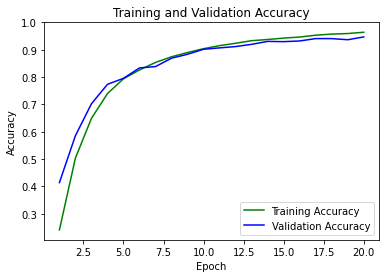

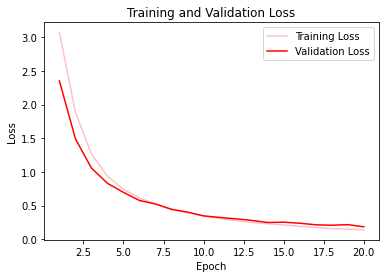

In [17]:
# Plotting Accuracy and Loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()

# Loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [18]:
model.save('baseline_model.h5')

* ### Model 1

In [19]:


model = Sequential()

# Convolutional Step 1
model.add(Conv2D(input_shape=(30,30,3), filters=32, kernel_size=(5,5), padding="same", activation="relu"))

# Max Pooling Step 1
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# Convolutional Step 2
model.add(Conv2D(filters=32, kernel_size=(5,5), padding="same", activation="relu"))

# Max Pooling Step 2
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# Flatten Step
model.add(Flatten())

############################
#  FULLY CONNECTED LAYERS  #
############################

# Fully Connected Layer 1
model.add(Dense(units=128,activation="relu", kernel_initializer='he_uniform'))

# Fully Connected Layer 2
model.add(Dense(units=43, activation="softmax")) 

print("MODEL SUMMARY\n")

model.summary()

MODEL SUMMARY

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 32)        2432      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 32)        25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               200832    
_________________________________________________________________
dense_3 (Dense)              (None, 43)

In [20]:
# Compiling the model
model.compile(optimizer=Adam(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

In [21]:
# Defining batch and epoch sizes
batch_size = 64
epochs = 20

# Fitting the model with train and validation datasets.
history = model.fit(X_train, 
                    y_train, 
                    batch_size=batch_size,
                    epochs = epochs,
                    validation_data = (X_val, y_val),
                    steps_per_epoch = X_train.shape[0] // batch_size)

Epoch 1/20
490/490 [==============================] - 16s 31ms/step - loss: 3.2827 - accuracy: 0.1763 - val_loss: 1.8676 - val_accuracy: 0.5246
Epoch 2/20
490/490 [==============================] - 15s 32ms/step - loss: 1.6040 - accuracy: 0.5757 - val_loss: 0.9989 - val_accuracy: 0.7270
Epoch 3/20
490/490 [==============================] - 15s 31ms/step - loss: 0.9298 - accuracy: 0.7450 - val_loss: 0.7311 - val_accuracy: 0.7938
Epoch 4/20
490/490 [==============================] - 16s 32ms/step - loss: 0.6719 - accuracy: 0.8122 - val_loss: 0.5570 - val_accuracy: 0.8428
Epoch 5/20
490/490 [==============================] - 16s 32ms/step - loss: 0.5252 - accuracy: 0.8533 - val_loss: 0.4605 - val_accuracy: 0.8659
Epoch 6/20
490/490 [==============================] - 15s 31ms/step - loss: 0.4057 - accuracy: 0.8864 - val_loss: 0.3793 - val_accuracy: 0.8860
Epoch 7/20
490/490 [==============================] - 15s 32ms/step - loss: 0.3448 - accuracy: 0.9056 - val_loss: 0.3343 - val_accuracy:

In [22]:
best_val_accuracy = max(history.history['val_accuracy'])
print("Best Validation Accuracy: %",best_val_accuracy*100)

Best Validation Accuracy: % 96.51874303817749


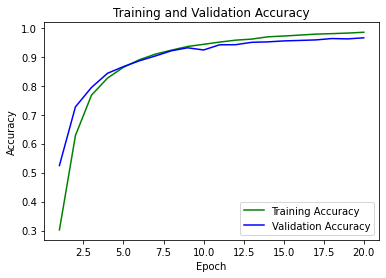

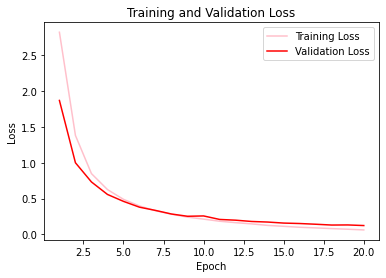

In [23]:
# Plotting Accuracy and Loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()

# Loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [24]:
model.save('model1.h5')

* ### Evaluation of the Model 1

In [25]:
from keras.models import load_model
model = load_model('model1.h5')

In [26]:
model.metrics_names

['loss', 'accuracy']

In [27]:
model.evaluate(X_val,y_val)

246/246 [==============================] - 1s 3ms/step - loss: 0.1234 - accuracy: 0.9652


[0.12341418862342834, 0.9651874303817749]

In [28]:
predictions = model.predict_classes(X_val)#hangi nörondan çıkttıgını verir.

In [29]:
predictions

array([ 8, 30, 28, ..., 17, 15, 35], dtype=int64)

In [39]:
# Converting from One-Hot Encoding to original classes
y_val_org = np.array([np.where(r==1)[0][0] for r in y_val])
y_val_org

array([ 4, 30, 28, ..., 17, 15, 35], dtype=int64)

* ### Classification Report for Model 1

In [40]:
print(classification_report(y_val_org, predictions))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90        38
           1       0.94      0.98      0.96       496
           2       0.97      0.95      0.96       420
           3       0.94      0.95      0.95       294
           4       0.98      0.96      0.97       400
           5       0.92      0.91      0.91       364
           6       0.95      1.00      0.97        69
           7       0.99      0.87      0.93       313
           8       0.91      0.99      0.95       274
           9       0.95      1.00      0.97       277
          10       0.98      0.98      0.98       398
          11       0.96      0.98      0.97       261
          12       1.00      0.99      1.00       443
          13       1.00      0.99      1.00       422
          14       1.00      0.98      0.99       135
          15       0.99      0.96      0.97       118
          16       1.00      0.99      0.99        86
          17       0.99    

* ### Confusion Matrix for Model 1

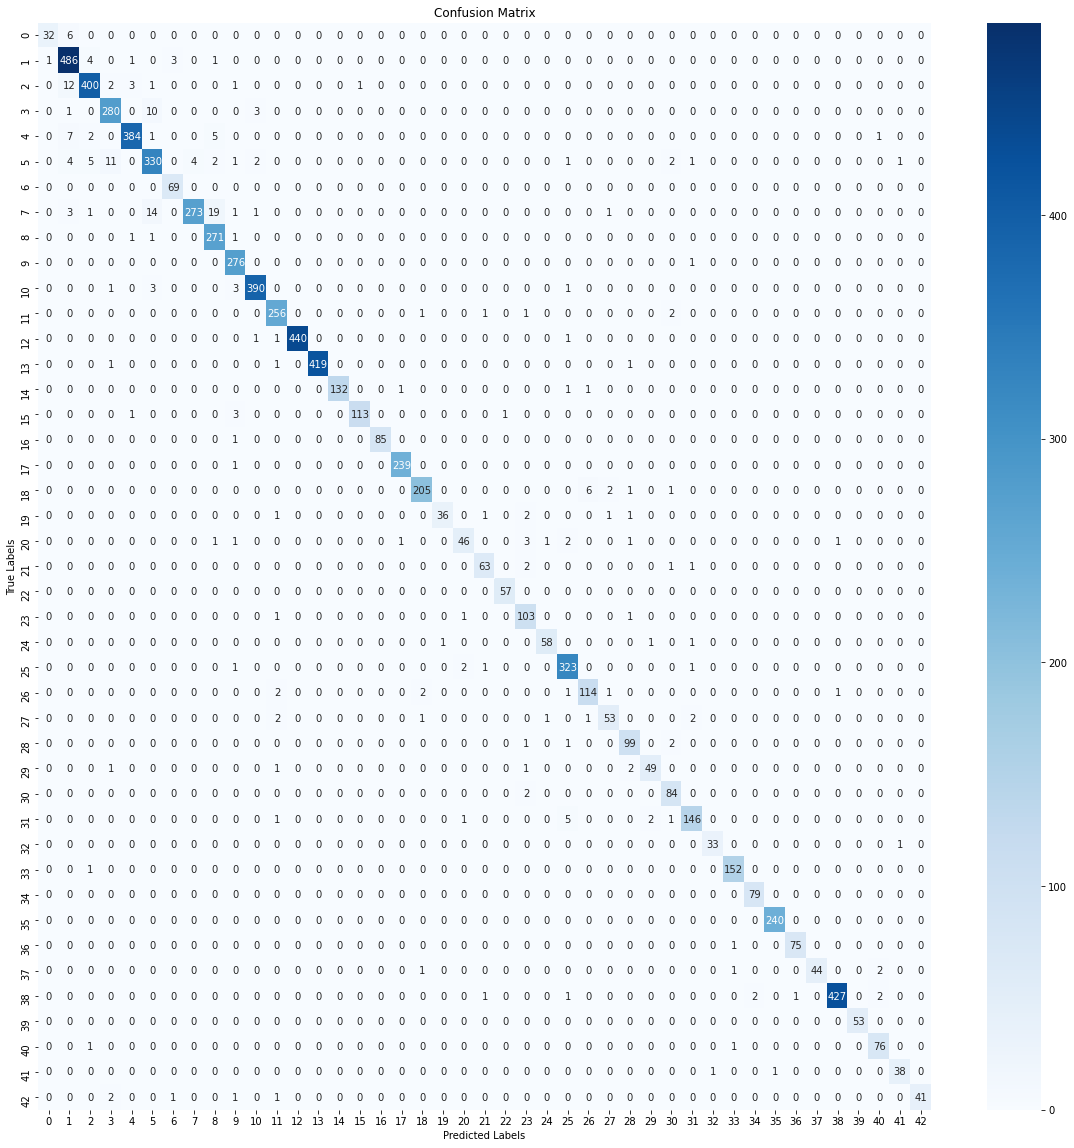

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Creating the confusion matrix
conf_matrix = confusion_matrix(y_val_org, predictions)
f, ax = plt.subplots(figsize = (20,20))

sns.heatmap(conf_matrix, annot=True, fmt='.0f', ax = ax, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();

* ### Model 1 with SGD Optimizer

In [43]:
model = Sequential()

# Convolutional Step 1
model.add(Conv2D(input_shape=(30,30,3), filters=32, kernel_size=(5,5), padding="same", activation="relu"))

# Max Pooling Step 1
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# Convolutional Step 2
model.add(Conv2D(filters=32, kernel_size=(5,5), padding="same", activation="relu"))

# Max Pooling Step 2
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# Flatten Step
model.add(Flatten())

############################
#  FULLY CONNECTED LAYERS  #
############################

# Fully Connected Layer 1
model.add(Dense(units=128,activation="relu", kernel_initializer='he_uniform'))

# Fully Connected Layer 2
model.add(Dense(units=43, activation="softmax")) 

print("MODEL SUMMARY\n")

model.summary()

MODEL SUMMARY

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        2432      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 15, 32)        25632     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               200832    
_________________________________________________________________
dense_5 (Dense)              (None, 43)

In [44]:
# Compiling the model
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

In [45]:
# Defining batch and epoch sizes
batch_size = 64
epochs = 20

# Fitting the model with train and validation datasets.
history = model.fit(X_train, 
                    y_train, 
                    batch_size=batch_size,
                    epochs = epochs,
                    validation_data = (X_val, y_val),
                    steps_per_epoch = X_train.shape[0] // batch_size)

Epoch 1/20
490/490 [==============================] - 16s 32ms/step - loss: 3.7463 - accuracy: 0.0593 - val_loss: 3.6457 - val_accuracy: 0.0726
Epoch 2/20
490/490 [==============================] - 15s 31ms/step - loss: 3.6068 - accuracy: 0.0664 - val_loss: 3.4903 - val_accuracy: 0.0724
Epoch 3/20
490/490 [==============================] - 16s 32ms/step - loss: 3.4769 - accuracy: 0.0751 - val_loss: 3.4178 - val_accuracy: 0.1067
Epoch 4/20
490/490 [==============================] - 16s 32ms/step - loss: 3.4269 - accuracy: 0.1052 - val_loss: 3.3634 - val_accuracy: 0.1465
Epoch 5/20
490/490 [==============================] - 15s 31ms/step - loss: 3.3653 - accuracy: 0.1324 - val_loss: 3.3001 - val_accuracy: 0.1697
Epoch 6/20
490/490 [==============================] - 15s 31ms/step - loss: 3.2982 - accuracy: 0.1615 - val_loss: 3.2062 - val_accuracy: 0.2155
Epoch 7/20
490/490 [==============================] - 15s 31ms/step - loss: 3.2018 - accuracy: 0.1980 - val_loss: 3.0829 - val_accuracy:

In [46]:
best_val_accuracy = max(history.history['val_accuracy'])
print("Best Validation Accuracy: %",best_val_accuracy*100)

Best Validation Accuracy: % 73.98622632026672


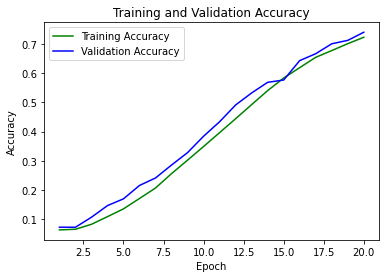

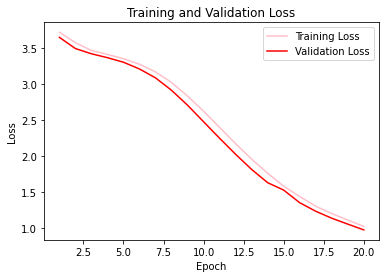

In [47]:
# Plotting Accuracy and Loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()

# Loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

* ### Model 2

In [55]:


model = Sequential()

# Convolutional Step 1
model.add(Conv2D(input_shape=(30,30,3), filters=32, kernel_size=(3,3), padding="same", activation="relu"))

# Max Pooling Step 1
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# Convolutional Step 2
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))

# Max Pooling Step 2
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# Flatten Step
model.add(Flatten())

############################
#  FULLY CONNECTED LAYERS  #
############################

# Fully Connected Layer 1
model.add(Dense(units=128,activation="relu", kernel_initializer='he_uniform'))

# Fully Connected Layer 2
model.add(Dense(units=43, activation="softmax")) 

print("MODEL SUMMARY\n")

model.summary()

MODEL SUMMARY

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               200832    
_________________________________________________________________
dense_11 (Dense)             (None, 43)

In [56]:
# Compiling the model
model.compile(optimizer=Adam(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

In [57]:
# Defining batch and epoch sizes
batch_size = 64
epochs = 25

# Fitting the model with train and validation datasets.
history = model.fit(X_train, 
                    y_train, 
                    batch_size=batch_size,
                    epochs = epochs,
                    validation_data = (X_val, y_val),
                    steps_per_epoch = X_train.shape[0] // batch_size)

Epoch 1/25
490/490 [==============================] - 9s 19ms/step - loss: 3.3665 - accuracy: 0.1550 - val_loss: 2.0320 - val_accuracy: 0.4693
Epoch 2/25
490/490 [==============================] - 9s 19ms/step - loss: 1.7726 - accuracy: 0.5294 - val_loss: 1.1652 - val_accuracy: 0.6866
Epoch 3/25
490/490 [==============================] - 9s 19ms/step - loss: 1.0689 - accuracy: 0.7086 - val_loss: 0.8060 - val_accuracy: 0.7737
Epoch 4/25
490/490 [==============================] - 10s 19ms/step - loss: 0.7166 - accuracy: 0.8060 - val_loss: 0.5920 - val_accuracy: 0.8423
Epoch 5/25
490/490 [==============================] - 10s 20ms/step - loss: 0.5436 - accuracy: 0.8538 - val_loss: 0.4795 - val_accuracy: 0.8670
Epoch 6/25
490/490 [==============================] - 9s 19ms/step - loss: 0.4318 - accuracy: 0.8852 - val_loss: 0.4113 - val_accuracy: 0.8831
Epoch 7/25
490/490 [==============================] - 9s 19ms/step - loss: 0.3506 - accuracy: 0.9057 - val_loss: 0.3318 - val_accuracy: 0.91

In [58]:
best_val_accuracy = max(history.history['val_accuracy'])
print("Best Validation Accuracy: %",best_val_accuracy*100)

Best Validation Accuracy: % 97.13083505630493


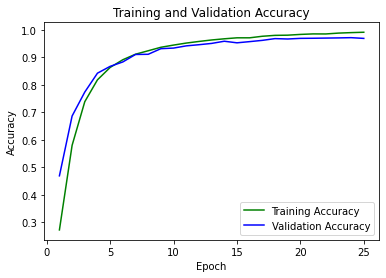

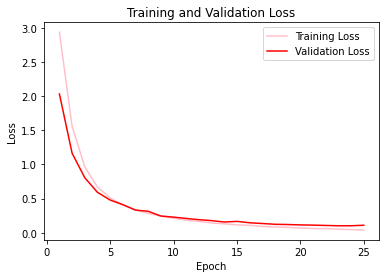

In [59]:
# Plotting Accuracy and Loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()

# Loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [60]:
model.save('model2.h5')

* ### Evaluation of the Model 2

In [61]:
from keras.models import load_model
model = load_model('model2.h5')

In [62]:
model.metrics_names

['loss', 'accuracy']

In [63]:
model.evaluate(X_val,y_val)

246/246 [==============================] - 1s 2ms/step - loss: 0.1104 - accuracy: 0.9686


[0.11042153090238571, 0.9686304330825806]

In [64]:
predictions = model.predict_classes(X_val)

In [65]:
predictions

array([ 4, 26, 28, ..., 17, 15, 35], dtype=int64)

In [66]:
# Converting from One-Hot Encoding to original classes
y_val_org = np.array([np.where(r==1)[0][0] for r in y_val])
y_val_org

array([ 4, 30, 28, ..., 17, 15, 35], dtype=int64)

* ### Classification Report for Model 2

In [67]:
print(classification_report(y_val_org, predictions))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        38
           1       0.95      0.98      0.96       496
           2       0.98      0.90      0.94       420
           3       0.87      0.97      0.92       294
           4       0.99      0.98      0.99       400
           5       0.92      0.91      0.91       364
           6       0.97      0.97      0.97        69
           7       0.98      0.91      0.95       313
           8       0.91      0.99      0.95       274
           9       0.98      0.99      0.99       277
          10       0.99      0.98      0.99       398
          11       0.98      0.97      0.97       261
          12       1.00      1.00      1.00       443
          13       1.00      0.99      0.99       422
          14       0.99      0.98      0.98       135
          15       0.99      0.97      0.98       118
          16       1.00      1.00      1.00        86
          17       1.00    

* ### Confusion Matrix for Model 2

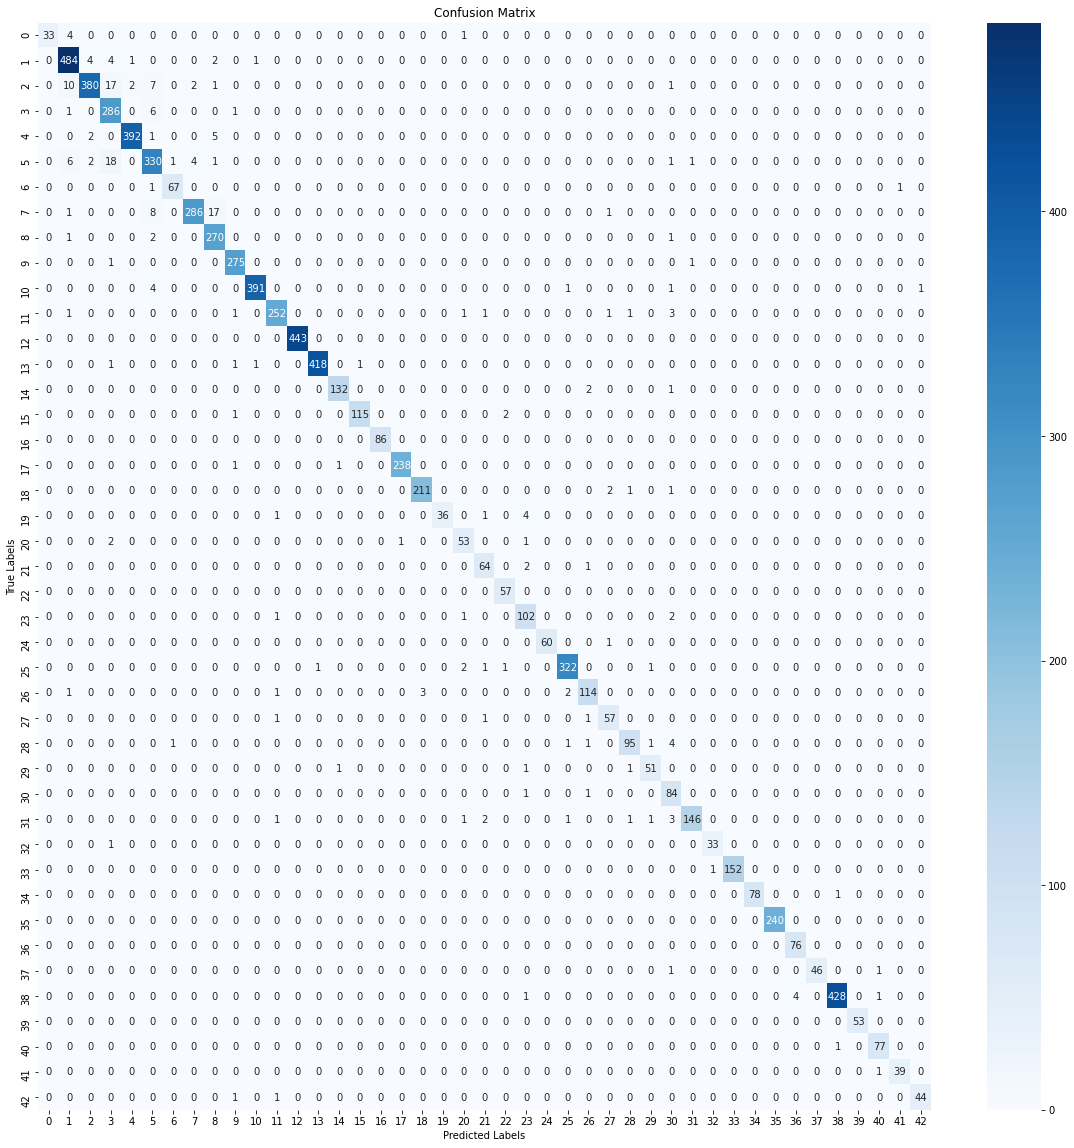

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Creating the confusion matrix
conf_matrix = confusion_matrix(y_val_org, predictions)
f, ax = plt.subplots(figsize = (20,20))

sns.heatmap(conf_matrix, annot=True, fmt='.0f', ax = ax, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();

* ### Model 3

In [69]:
model = Sequential()

# Convolutional Step 1
model.add(Conv2D(input_shape=(30,30,3), filters=32, kernel_size=(3,3), padding="same", activation="relu"))

# Convolutional Step 2
model.add(Conv2D(input_shape=(30,30,3), filters=32, kernel_size=(3,3), padding="same", activation="relu"))

# Max Pooling Step 1
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# Convolutional Step 3
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))

# Convolutional Step 4
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))

# Max Pooling Step 2
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# Flatten Step
model.add(Flatten())

############################
#  FULLY CONNECTED LAYERS  #
############################

# Fully Connected Layer 1
model.add(Dense(units=128,activation="relu", kernel_initializer='he_uniform'))

# Fully Connected Layer 2
model.add(Dense(units=43, activation="softmax")) 

print("MODEL SUMMARY\n")

model.summary()

MODEL SUMMARY

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 15, 32)        9248      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 156

In [70]:
# Compiling the model
model.compile(optimizer=Adam(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

In [71]:
# Defining batch and epoch sizes
batch_size = 64
epochs = 20

# Fitting the model with train and validation datasets.
history = model.fit(X_train, 
                    y_train, 
                    batch_size=batch_size,
                    epochs = epochs,
                    validation_data = (X_val, y_val),
                    steps_per_epoch = X_train.shape[0] // batch_size)

Epoch 1/20
490/490 [==============================] - 27s 54ms/step - loss: 3.1523 - accuracy: 0.1885 - val_loss: 1.1413 - val_accuracy: 0.6781
Epoch 2/20
490/490 [==============================] - 27s 55ms/step - loss: 0.9711 - accuracy: 0.7195 - val_loss: 0.5981 - val_accuracy: 0.8201
Epoch 3/20
490/490 [==============================] - 26s 54ms/step - loss: 0.5406 - accuracy: 0.8390 - val_loss: 0.4541 - val_accuracy: 0.8553
Epoch 4/20
490/490 [==============================] - 27s 54ms/step - loss: 0.3490 - accuracy: 0.8974 - val_loss: 0.3091 - val_accuracy: 0.9022
Epoch 5/20
490/490 [==============================] - 26s 54ms/step - loss: 0.2491 - accuracy: 0.9269 - val_loss: 0.2248 - val_accuracy: 0.9352
Epoch 6/20
490/490 [==============================] - 30s 62ms/step - loss: 0.1873 - accuracy: 0.9437 - val_loss: 0.2228 - val_accuracy: 0.9319
Epoch 7/20
490/490 [==============================] - 30s 61ms/step - loss: 0.1464 - accuracy: 0.9563 - val_loss: 0.1672 - val_accuracy:

In [72]:
best_val_accuracy = max(history.history['val_accuracy'])
print("Best Validation Accuracy: %",best_val_accuracy*100)

Best Validation Accuracy: % 97.90869951248169


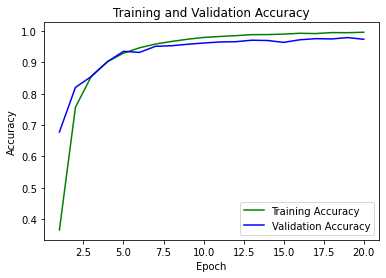

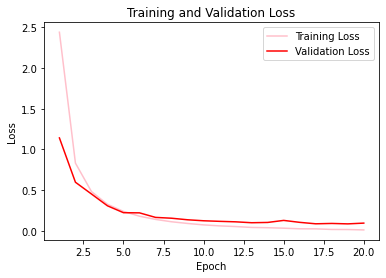

In [73]:
# Plotting Accuracy and Loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()

# Loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [74]:
model.save('model3.h5')

* ### Evaluation of the Model 3

In [75]:
from keras.models import load_model
model = load_model('model3.h5')

In [76]:
model.metrics_names

['loss', 'accuracy']

In [77]:
model.evaluate(X_val,y_val)

246/246 [==============================] - 1s 4ms/step - loss: 0.0971 - accuracy: 0.9736


[0.09706423431634903, 0.9736036658287048]

In [64]:
predictions = model.predict_classes(X_val)

In [65]:
predictions

array([ 4, 26, 28, ..., 17, 15, 35], dtype=int64)

In [78]:
# Converting from One-Hot Encoding to original classes
y_val_org = np.array([np.where(r==1)[0][0] for r in y_val])
y_val_org

array([ 4, 30, 28, ..., 17, 15, 35], dtype=int64)

* ### Classification Report for Model 3

In [79]:
print(classification_report(y_val_org, predictions))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        38
           1       0.95      0.98      0.96       496
           2       0.98      0.90      0.94       420
           3       0.87      0.97      0.92       294
           4       0.99      0.98      0.99       400
           5       0.92      0.91      0.91       364
           6       0.97      0.97      0.97        69
           7       0.98      0.91      0.95       313
           8       0.91      0.99      0.95       274
           9       0.98      0.99      0.99       277
          10       0.99      0.98      0.99       398
          11       0.98      0.97      0.97       261
          12       1.00      1.00      1.00       443
          13       1.00      0.99      0.99       422
          14       0.99      0.98      0.98       135
          15       0.99      0.97      0.98       118
          16       1.00      1.00      1.00        86
          17       1.00    

* ### Confusion Matrix for Model 3

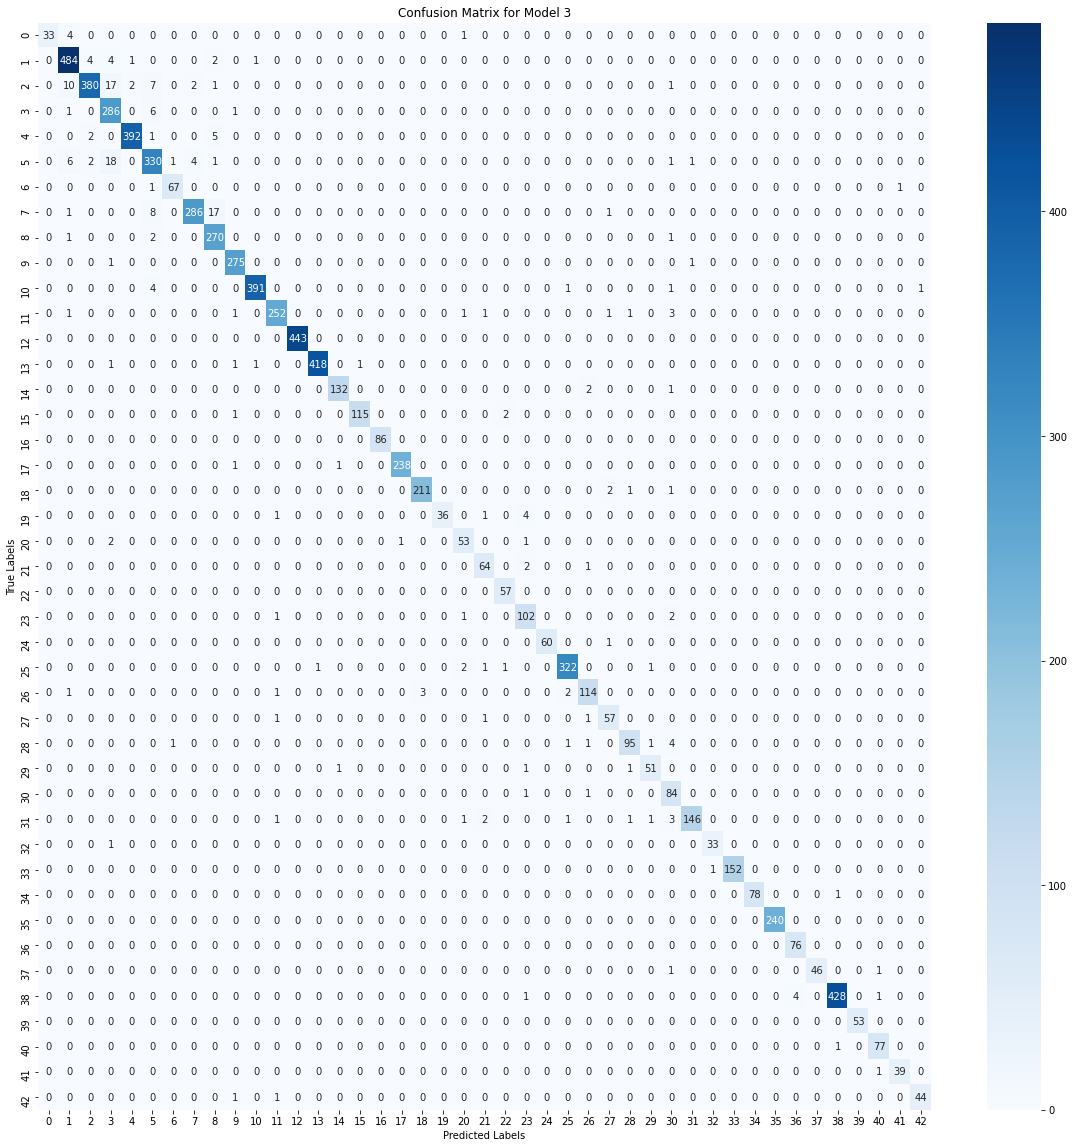

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Creating the confusion matrix
conf_matrix = confusion_matrix(y_val_org, predictions)
f, ax = plt.subplots(figsize = (20,20))

sns.heatmap(conf_matrix, annot=True, fmt='.0f', ax = ax, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Model 3')
plt.show();

* ### Model 4

In [82]:
model = Sequential()

# Convolutional Step 1
model.add(Conv2D(input_shape=(30,30,3), filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())

# Convolutional Step 2
model.add(Conv2D(input_shape=(30,30,3), filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())

# Max Pooling Step 1
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# Convolutional Step 3
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())

# Convolutional Step 4
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())

# Max Pooling Step 2
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# Flatten Step
model.add(Flatten())

############################
#  FULLY CONNECTED LAYERS  #
############################

# Fully Connected Layer 1
model.add(Dense(units=128,activation="relu", kernel_initializer='he_uniform'))

# Fully Connected Layer 2
model.add(Dense(units=43, activation="softmax")) 

print("MODEL SUMMARY\n")

model.summary()

MODEL SUMMARY

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 15, 15, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15,

In [83]:
# Compiling the model
model.compile(optimizer=Adam(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

In [84]:
# Defining batch and epoch sizes
batch_size = 64
epochs = 20

# Fitting the model with train and validation datasets.
history = model.fit(X_train, 
                    y_train, 
                    batch_size=batch_size,
                    epochs = epochs,
                    validation_data = (X_val, y_val),
                    steps_per_epoch = X_train.shape[0] // batch_size)

Epoch 1/20
490/490 [==============================] - 50s 101ms/step - loss: 2.6911 - accuracy: 0.3342 - val_loss: 1.0995 - val_accuracy: 0.7079
Epoch 2/20
490/490 [==============================] - 52s 105ms/step - loss: 0.5850 - accuracy: 0.8387 - val_loss: 0.3259 - val_accuracy: 0.9079
Epoch 3/20
490/490 [==============================] - 49s 100ms/step - loss: 0.2338 - accuracy: 0.9421 - val_loss: 0.1895 - val_accuracy: 0.9464
Epoch 4/20
490/490 [==============================] - 53s 107ms/step - loss: 0.1155 - accuracy: 0.9768 - val_loss: 0.1280 - val_accuracy: 0.9649
Epoch 5/20
490/490 [==============================] - 50s 102ms/step - loss: 0.0675 - accuracy: 0.9881 - val_loss: 0.0986 - val_accuracy: 0.9732
Epoch 6/20
490/490 [==============================] - 50s 102ms/step - loss: 0.0420 - accuracy: 0.9940 - val_loss: 0.0794 - val_accuracy: 0.9790
Epoch 7/20
490/490 [==============================] - 56s 114ms/step - loss: 0.0256 - accuracy: 0.9982 - val_loss: 0.0680 - val_ac

In [85]:
best_val_accuracy = max(history.history['val_accuracy'])
print("Best Validation Accuracy: %",best_val_accuracy*100)

Best Validation Accuracy: % 99.12012219429016


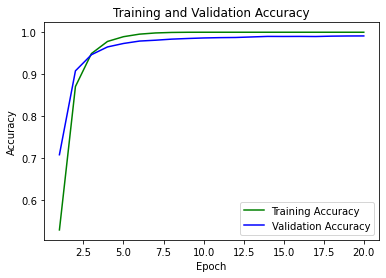

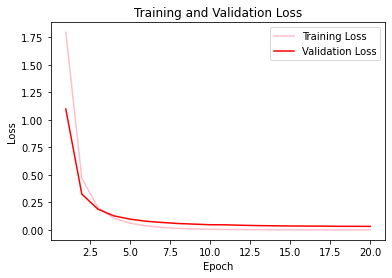

In [86]:
# Plotting Accuracy and Loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()

# Loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [87]:
model.save('model4.h5')

* ### Evaluation of the Model 4

In [88]:
from keras.models import load_model
model = load_model('model4.h5')

In [89]:
model.metrics_names

['loss', 'accuracy']

In [90]:
model.evaluate(X_val,y_val)

246/246 [==============================] - 2s 7ms/step - loss: 0.0325 - accuracy: 0.9912


[0.032549627125263214, 0.9912012219429016]

In [91]:
predictions = model.predict_classes(X_val)

In [92]:
predictions

array([ 4, 30, 28, ..., 17, 15, 35], dtype=int64)

In [93]:
# Converting from One-Hot Encoding to original classes
y_val_org = np.array([np.where(r==1)[0][0] for r in y_val])
y_val_org

array([ 4, 30, 28, ..., 17, 15, 35], dtype=int64)

* ### Classification Report for Model 4

In [94]:
print(classification_report(y_val_org, predictions))

              precision    recall  f1-score   support

           0       0.94      0.89      0.92        38
           1       0.99      0.99      0.99       496
           2       0.99      1.00      0.99       420
           3       0.99      0.99      0.99       294
           4       0.99      1.00      1.00       400
           5       0.98      0.98      0.98       364
           6       1.00      1.00      1.00        69
           7       0.99      0.99      0.99       313
           8       1.00      0.99      0.99       274
           9       0.99      1.00      0.99       277
          10       1.00      0.99      1.00       398
          11       0.98      0.99      0.99       261
          12       1.00      1.00      1.00       443
          13       1.00      1.00      1.00       422
          14       1.00      0.99      1.00       135
          15       1.00      1.00      1.00       118
          16       0.99      1.00      0.99        86
          17       0.99    

* ### Confusion Matrix for Model 4

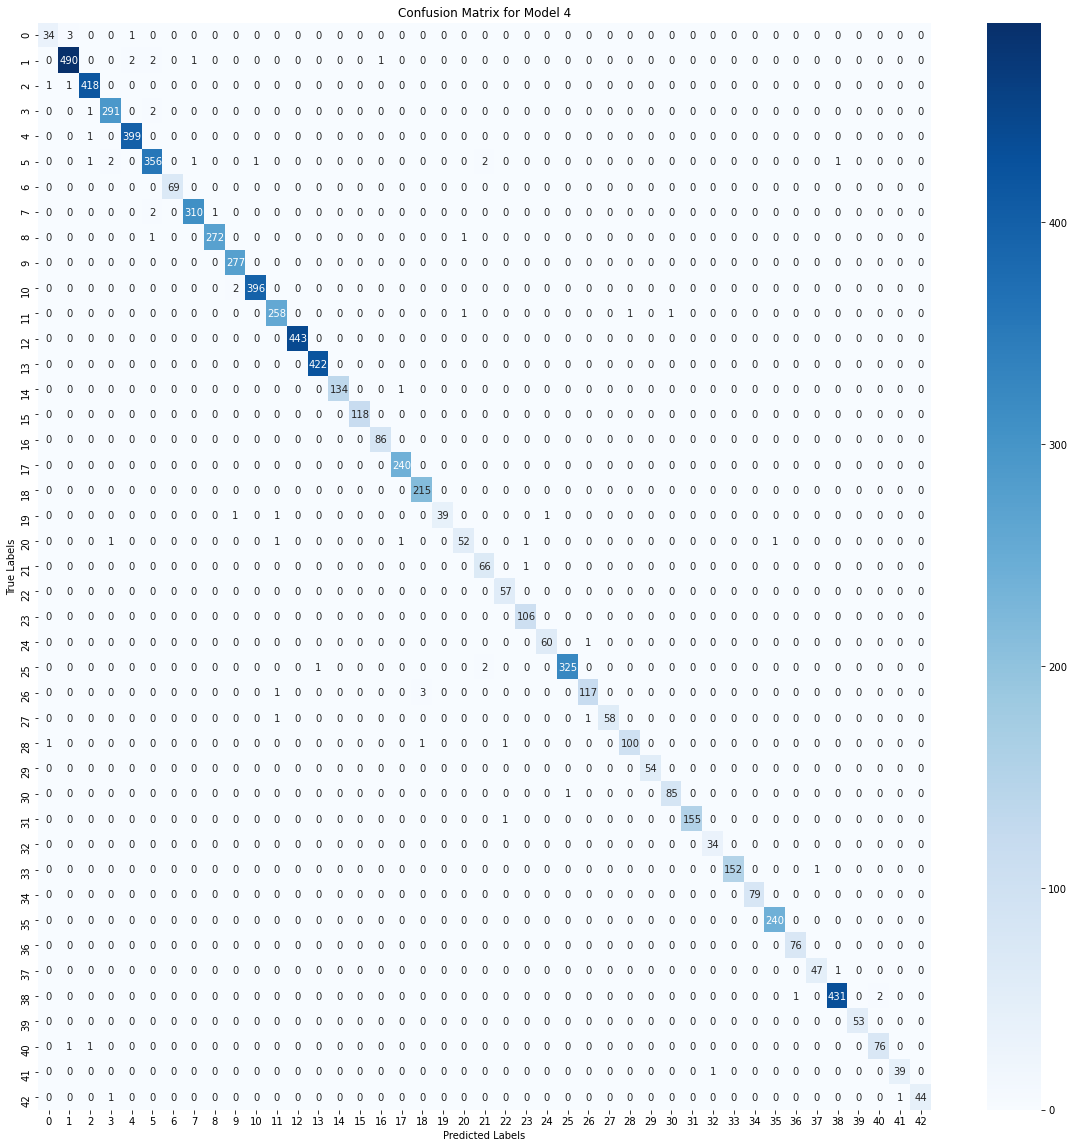

In [95]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Creating the confusion matrix
conf_matrix = confusion_matrix(y_val_org, predictions)
f, ax = plt.subplots(figsize = (20,20))

sns.heatmap(conf_matrix, annot=True, fmt='.0f', ax = ax, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Model 4')
plt.show();

* ### Model 5

In [96]:
model = Sequential()

# Convolutional Step 1
model.add(Conv2D(input_shape=(30,30,3), filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())

# Convolutional Step 2
model.add(Conv2D(input_shape=(30,30,3), filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())

# Max Pooling Step 1
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# Convolutional Step 3
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())

# Convolutional Step 4
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())

# Max Pooling Step 2
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# Flatten Step
model.add(Flatten())
model.add(Dropout(0.3))

############################
#  FULLY CONNECTED LAYERS  #
############################

# Fully Connected Layer 1
model.add(Dense(units=256,activation="relu", kernel_initializer='he_uniform'))
model.add(Dropout(0.2))

# Fully Connected Layer 2
model.add(Dense(units=128,activation="relu", kernel_initializer='he_uniform'))
model.add(Dropout(0.2))

# Fully Connected Layer 3
model.add(Dense(units=43, activation="softmax")) 

print("MODEL SUMMARY\n")

model.summary()

MODEL SUMMARY

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 15, 15, 32)        9248      
_________________________________________________________________
batch_normalization_6 (Batch (None, 15,

In [97]:
# Compiling the model
model.compile(optimizer=Adam(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

In [98]:
# Defining batch and epoch sizes
batch_size = 64
epochs = 20

# Fitting the model with train and validation datasets.
history = model.fit(X_train, 
                    y_train, 
                    batch_size=batch_size,
                    epochs = epochs,
                    validation_data = (X_val, y_val),
                    steps_per_epoch = X_train.shape[0] // batch_size)

Epoch 1/20
490/490 [==============================] - 54s 109ms/step - loss: 3.7440 - accuracy: 0.1355 - val_loss: 1.9178 - val_accuracy: 0.5254
Epoch 2/20
490/490 [==============================] - 54s 111ms/step - loss: 1.9029 - accuracy: 0.4654 - val_loss: 0.8335 - val_accuracy: 0.7666
Epoch 3/20
490/490 [==============================] - 48s 98ms/step - loss: 1.1715 - accuracy: 0.6415 - val_loss: 0.4442 - val_accuracy: 0.8883
Epoch 4/20
490/490 [==============================] - 48s 98ms/step - loss: 0.7423 - accuracy: 0.7627 - val_loss: 0.2643 - val_accuracy: 0.9310
Epoch 5/20
490/490 [==============================] - 52s 106ms/step - loss: 0.5249 - accuracy: 0.8290 - val_loss: 0.1781 - val_accuracy: 0.9526
Epoch 6/20
490/490 [==============================] - 53s 109ms/step - loss: 0.3779 - accuracy: 0.8770 - val_loss: 0.1202 - val_accuracy: 0.9704
Epoch 7/20
490/490 [==============================] - 53s 109ms/step - loss: 0.2897 - accuracy: 0.9046 - val_loss: 0.0895 - val_accu

In [99]:
best_val_accuracy = max(history.history['val_accuracy'])
print("Best Validation Accuracy: %",best_val_accuracy*100)

Best Validation Accuracy: % 99.54093098640442


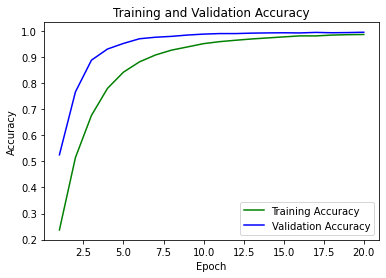

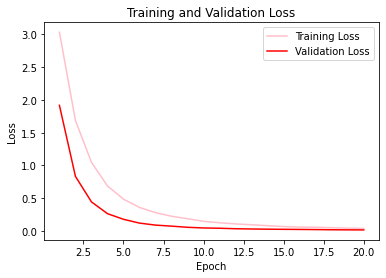

In [100]:
# Plotting Accuracy and Loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()

# Loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [101]:
model.save('model5.h5')

* ### Evaluation of the Model 5

In [102]:
from keras.models import load_model
model = load_model('model5.h5')

In [103]:
model.metrics_names

['loss', 'accuracy']

In [104]:
model.evaluate(X_val,y_val)

246/246 [==============================] - 2s 6ms/step - loss: 0.0161 - accuracy: 0.9954


[0.016110524535179138, 0.9954093098640442]

In [105]:
predictions = model.predict_classes(X_val)

In [106]:
predictions

array([ 4, 30, 28, ..., 17, 15, 35], dtype=int64)

In [107]:
# Converting from One-Hot Encoding to original classes
y_val_org = np.array([np.where(r==1)[0][0] for r in y_val])
y_val_org

array([ 4, 30, 28, ..., 17, 15, 35], dtype=int64)

* ### Classification Report for Model 5

In [108]:
print(classification_report(y_val_org, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      0.99      0.99       496
           2       0.99      0.99      0.99       420
           3       0.99      1.00      1.00       294
           4       1.00      1.00      1.00       400
           5       0.98      0.99      0.98       364
           6       0.99      1.00      0.99        69
           7       1.00      0.99      0.99       313
           8       1.00      0.99      0.99       274
           9       1.00      1.00      1.00       277
          10       1.00      1.00      1.00       398
          11       0.99      1.00      1.00       261
          12       1.00      1.00      1.00       443
          13       0.99      1.00      1.00       422
          14       1.00      0.99      1.00       135
          15       1.00      1.00      1.00       118
          16       1.00      1.00      1.00        86
          17       1.00    

* ### Confusion Matrix for Model 5

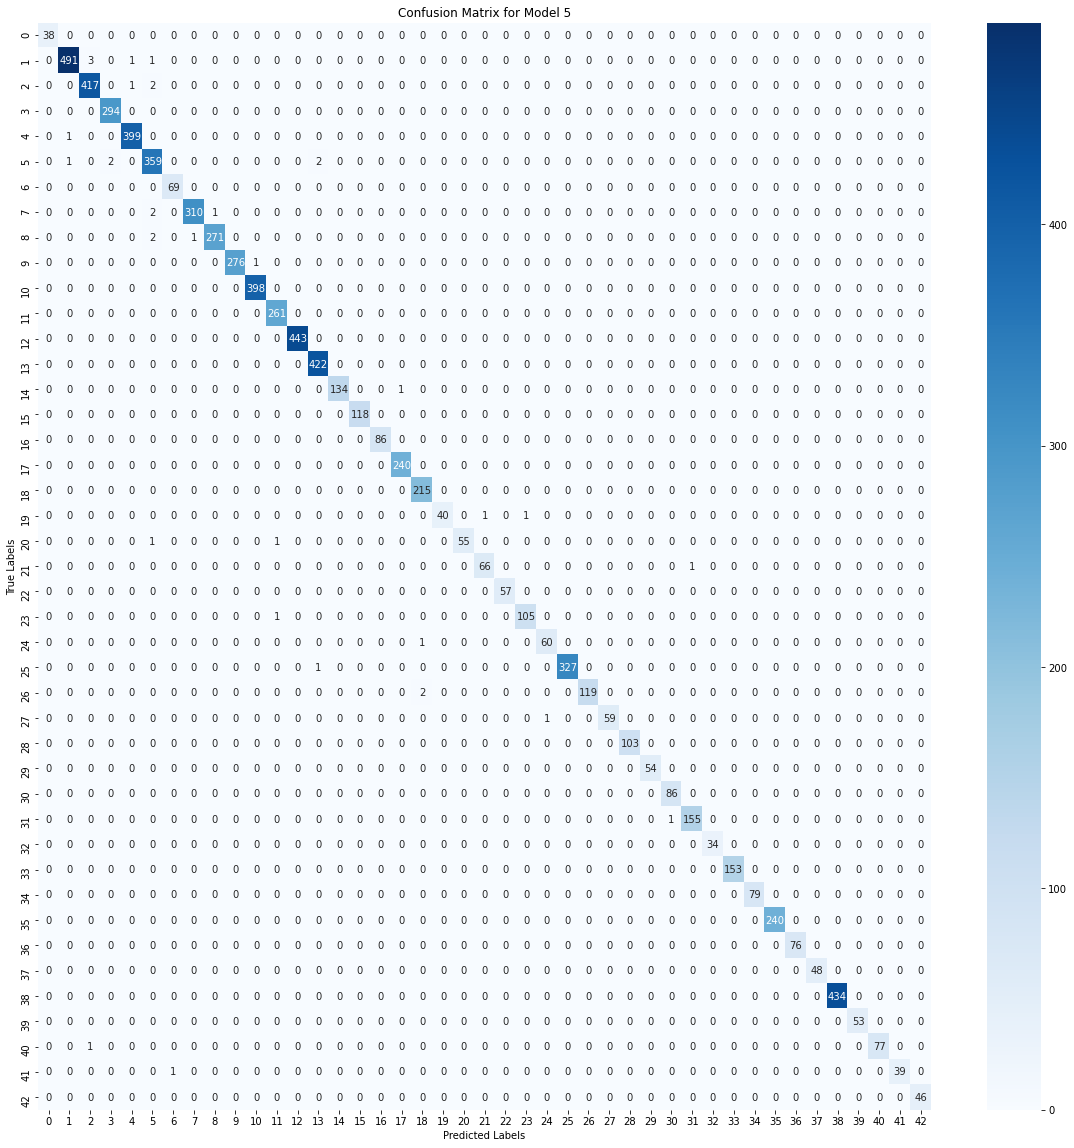

In [109]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Creating the confusion matrix
conf_matrix = confusion_matrix(y_val_org, predictions)
f, ax = plt.subplots(figsize = (20,20))

sns.heatmap(conf_matrix, annot=True, fmt='.0f', ax = ax, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Model 5')
plt.show();

* ### Model 6

In [15]:
model = Sequential()

# Convolutional Step 1
model.add(Conv2D(input_shape=(30,30,3), filters=16, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())

# Convolutional Step 2
model.add(Conv2D(input_shape=(30,30,3), filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())

# Max Pooling Step 1
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# Convolutional Step 3
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())

# Convolutional Step 4
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())

# Max Pooling Step 2
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# Flatten Step
model.add(Flatten())
model.add(Dropout(0.5))

############################
#  FULLY CONNECTED LAYERS  #
############################

# Fully Connected Layer 1
model.add(Dense(units=512,activation="relu", kernel_initializer='he_uniform'))
model.add(Dropout(0.5))

# Fully Connected Layer 2
model.add(Dense(units=256,activation="relu", kernel_initializer='he_uniform'))
model.add(Dropout(0.2))

# Fully Connected Layer 3
model.add(Dense(units=43, activation="softmax")) 

print("MODEL SUMMARY\n")

model.summary()

MODEL SUMMARY

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
batch_normalization_8 (Batch (None, 30, 30, 16)        64        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 32)        4640      
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 15,

In [16]:
# Compiling the model
model.compile(optimizer=Adam(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

In [18]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

In [20]:
# Defining batch and epoch sizes
batch_size = 64
epochs = 50

# Fitting the model with train and validation datasets.
history = model.fit(aug.flow(X_train, y_train, batch_size=batch_size),
                    epochs = epochs,
                    validation_data = (X_val, y_val),
                    steps_per_epoch = X_train.shape[0] // batch_size)

Epoch 1/50
490/490 [==============================] - 59s 119ms/step - loss: 4.3886 - accuracy: 0.1018 - val_loss: 2.3254 - val_accuracy: 0.4300
Epoch 2/50
490/490 [==============================] - 57s 117ms/step - loss: 2.6033 - accuracy: 0.2901 - val_loss: 1.4902 - val_accuracy: 0.5548
Epoch 3/50
490/490 [==============================] - 58s 117ms/step - loss: 2.0243 - accuracy: 0.3984 - val_loss: 1.1371 - val_accuracy: 0.6687
Epoch 4/50
490/490 [==============================] - 58s 117ms/step - loss: 1.6630 - accuracy: 0.4854 - val_loss: 0.8882 - val_accuracy: 0.7552
Epoch 5/50
490/490 [==============================] - 58s 118ms/step - loss: 1.4089 - accuracy: 0.5443 - val_loss: 0.6682 - val_accuracy: 0.7984
Epoch 6/50
490/490 [==============================] - 58s 118ms/step - loss: 1.1906 - accuracy: 0.6100 - val_loss: 0.5262 - val_accuracy: 0.8340
Epoch 7/50
490/490 [==============================] - 58s 118ms/step - loss: 1.0521 - accuracy: 0.6553 - val_loss: 0.4005 - val_ac

In [21]:
best_val_accuracy = max(history.history['val_accuracy'])
print("Best Validation Accuracy: %",best_val_accuracy*100)

Best Validation Accuracy: % 99.92349147796631


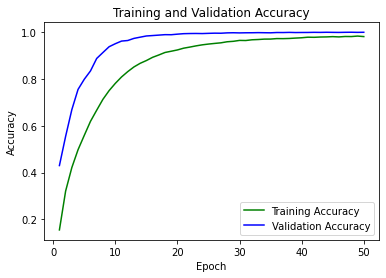

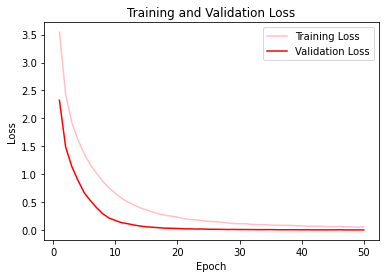

In [22]:
# Plotting Accuracy and Loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()

# Loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [23]:
model.save('model6.h5')

* ### Evaluation of the Model 6

In [13]:
from keras.models import load_model
model = load_model('model6.h5')

In [14]:
model.metrics_names

['loss', 'accuracy']

In [15]:
predictions = model.predict_classes(X_val)

In [16]:
predictions

array([ 4, 30, 28, ..., 17, 15, 35], dtype=int64)

In [17]:
# Converting from One-Hot Encoding to original classes
y_val_org = np.array([np.where(r==1)[0][0] for r in y_val])
y_val_org

array([ 4, 30, 28, ..., 17, 15, 35], dtype=int64)

* ### Classification Report for Model 6

In [18]:
print(classification_report(y_val_org, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       0.99      1.00      1.00       496
           2       1.00      1.00      1.00       420
           3       1.00      1.00      1.00       294
           4       1.00      0.99      1.00       400
           5       1.00      0.99      0.99       364
           6       1.00      1.00      1.00        69
           7       1.00      1.00      1.00       313
           8       1.00      1.00      1.00       274
           9       1.00      1.00      1.00       277
          10       1.00      1.00      1.00       398
          11       1.00      1.00      1.00       261
          12       1.00      1.00      1.00       443
          13       1.00      1.00      1.00       422
          14       1.00      1.00      1.00       135
          15       1.00      1.00      1.00       118
          16       1.00      1.00      1.00        86
          17       1.00    

* ### Confusion Matrix for Model 6

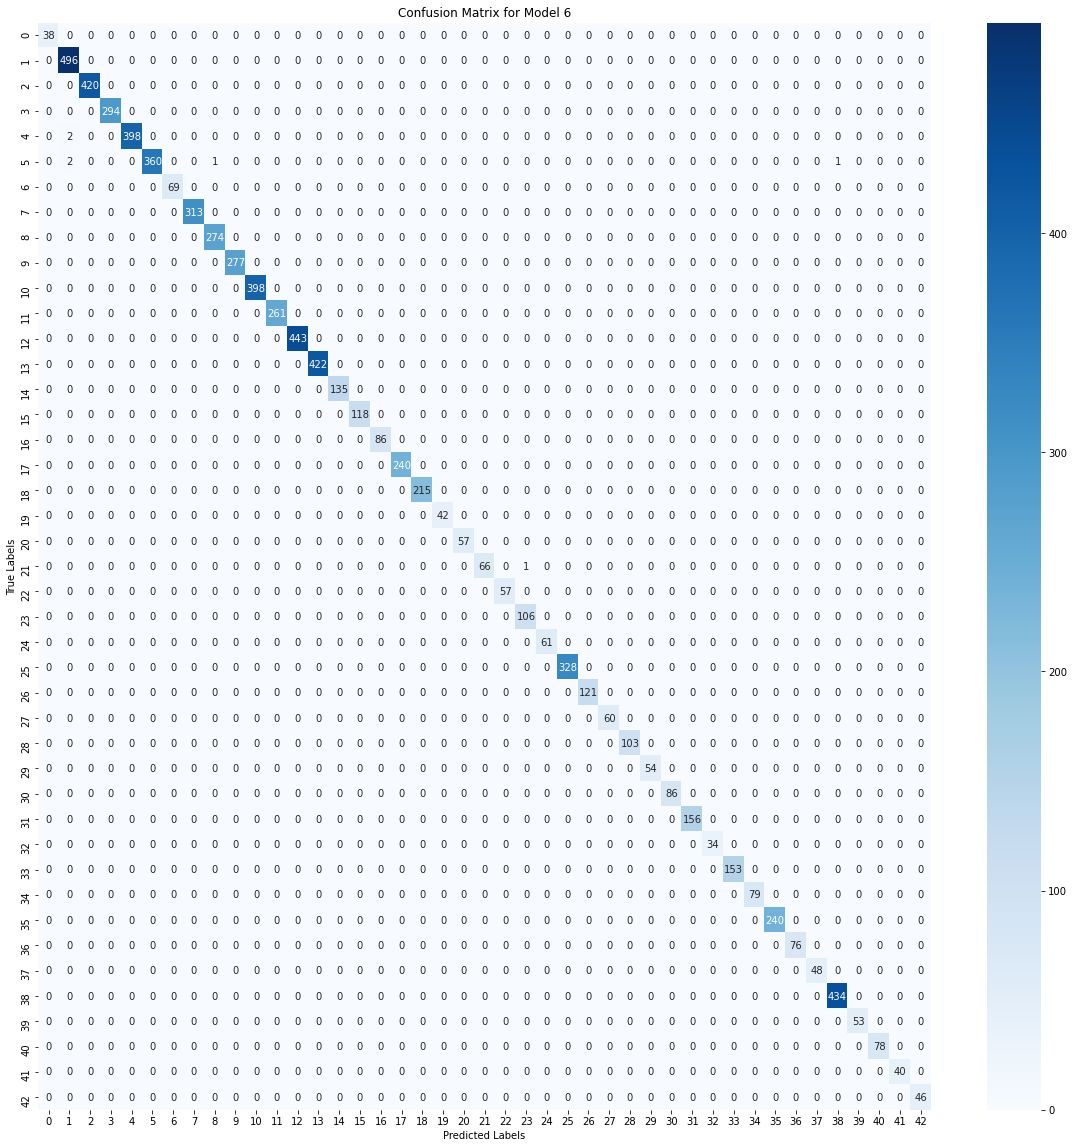

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Creating the confusion matrix
conf_matrix = confusion_matrix(y_val_org, predictions)
f, ax = plt.subplots(figsize = (20,20))

sns.heatmap(conf_matrix, annot=True, fmt='.0f', ax = ax, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Model 6')
plt.show();

## Prediction of the labels of the images in the Test Set

In [13]:
test_path = 'dataset/archive/Test'
test_data = pd.read_csv('dataset/archive/Test.csv')

labels = test_data["ClassId"].values
images = test_data["Path"].values

data = []

In [14]:
test_data

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
...,...,...,...,...,...,...,...,...
12625,42,41,5,6,37,36,12,Test/12625.png
12626,50,51,6,5,45,46,33,Test/12626.png
12627,29,29,6,6,24,24,6,Test/12627.png
12628,48,49,5,6,43,44,7,Test/12628.png


In [15]:
#Original Labels (Test Set)
print(labels)

[16  1 38 ...  6  7 10]


In [16]:
for i in os.listdir(test_path):
        img_path = test_path + '/' + i
        # Reading images
        img = cv2.imread(img_path)
        # OpenCV default color is BGR. So, we are converting it to RGB.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resizing the images
        img = cv2.resize(img, (30,30), interpolation = cv2.INTER_NEAREST)
        # Normalizing the images (Min-Max Normalization)
        img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        data.append(img)

In [17]:
data

[array([[[0.5777778 , 0.7055556 , 0.90000004],
         [0.5833334 , 0.7055556 , 0.89444447],
         [0.59444445, 0.70000005, 0.87222224],
         ...,
         [0.45555553, 0.5277778 , 0.6833334 ],
         [0.3888889 , 0.49444446, 0.6333334 ],
         [0.38333333, 0.50000006, 0.6388889 ]],
 
        [[0.59444445, 0.73333335, 0.9277778 ],
         [0.5833334 , 0.7166667 , 0.92222226],
         [0.58888894, 0.7111111 , 0.9055556 ],
         ...,
         [0.6055556 , 0.7055556 , 0.9111112 ],
         [0.6055556 , 0.7166667 , 0.88888896],
         [0.6       , 0.7111111 , 0.86666673]],
 
        [[0.59444445, 0.73333335, 0.92222226],
         [0.5833334 , 0.72222227, 0.9111112 ],
         [0.5833334 , 0.72222227, 0.9055556 ],
         ...,
         [0.6055556 , 0.72777784, 0.92222226],
         [0.61111116, 0.73333335, 0.9333334 ],
         [0.62222224, 0.7388889 , 0.92222226]],
 
        ...,
 
        [[0.58888894, 0.7055556 , 0.8777778 ],
         [0.5833334 , 0.70000005, 0.87777

In [18]:
len(data)

12630

In [19]:
X_test = np.array(data)

In [20]:
from keras.models import load_model

model = load_model('model6.h5')

In [21]:
predictions = model.predict_classes(X_test)

In [22]:
predictions

array([16,  1, 38, ...,  6,  7, 10], dtype=int64)

In [23]:
y_test = labels

#One-Hot Encoding with Keras
y_test = to_categorical(y_test)

model.evaluate(X_test, y_test)

395/395 [==============================] - 4s 9ms/step - loss: 0.1271 - accuracy: 0.9659


[0.1271226853132248, 0.9658749103546143]

* ### Classification Report

In [24]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97        60
           1       0.96      0.99      0.97       720
           2       0.98      0.99      0.99       750
           3       0.98      0.96      0.97       450
           4       0.99      0.96      0.97       660
           5       0.94      0.97      0.96       630
           6       0.99      0.97      0.98       150
           7       0.98      0.93      0.96       450
           8       0.92      0.95      0.94       450
           9       0.99      1.00      0.99       480
          10       1.00      0.98      0.99       660
          11       0.97      0.95      0.96       420
          12       1.00      0.99      0.99       690
          13       0.99      1.00      0.99       720
          14       0.99      1.00      1.00       270
          15       1.00      0.99      1.00       210
          16       1.00      1.00      1.00       150
          17       1.00    

## Confusion Matrix

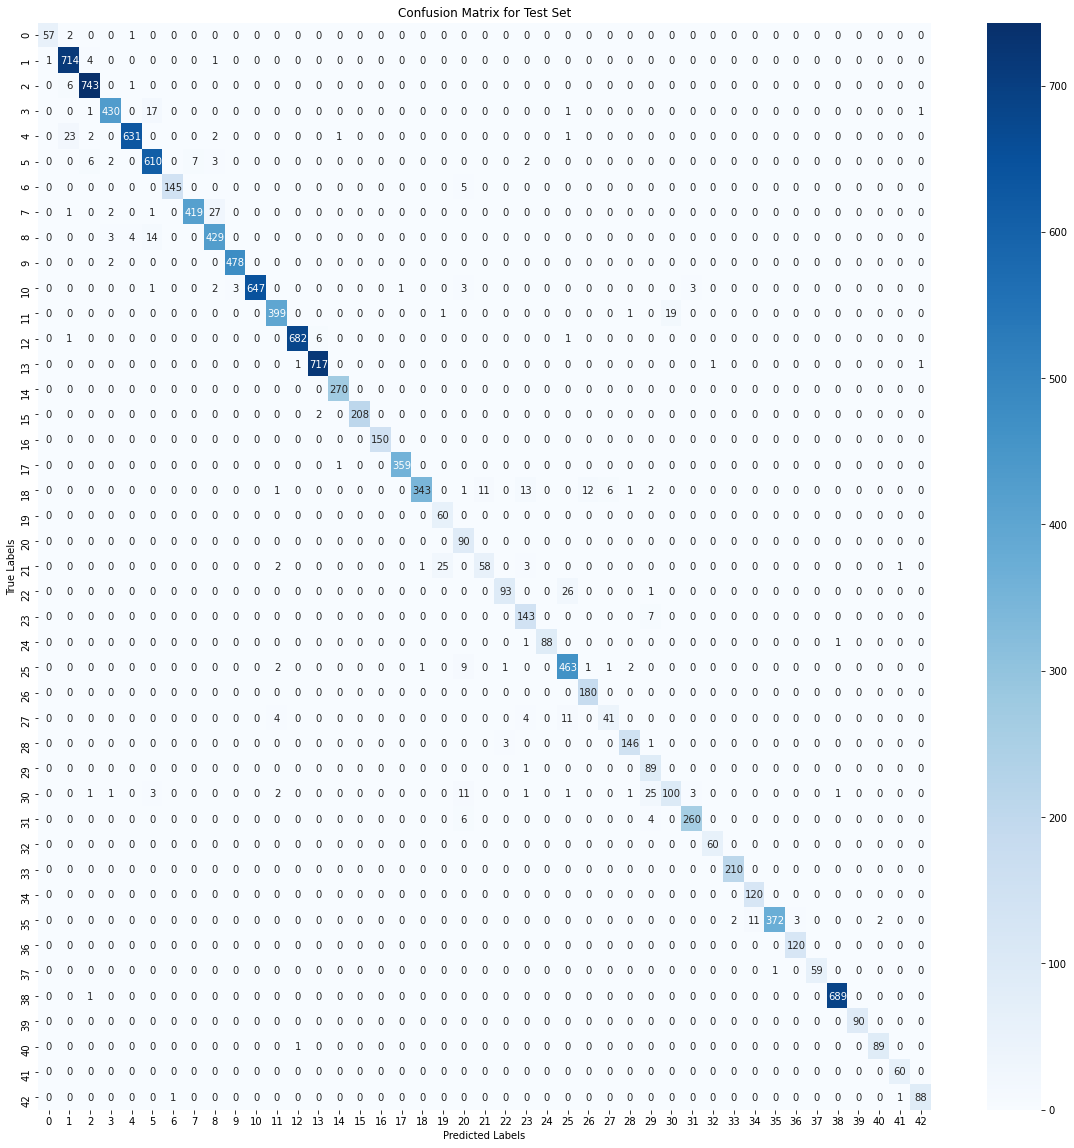

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Creating the confusion matrix
conf_matrix = confusion_matrix(labels, predictions)
f, ax = plt.subplots(figsize = (20,20))

sns.heatmap(conf_matrix, annot=True, fmt='.0f', ax = ax, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Set')
plt.show();

## Predictions on Test Data Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


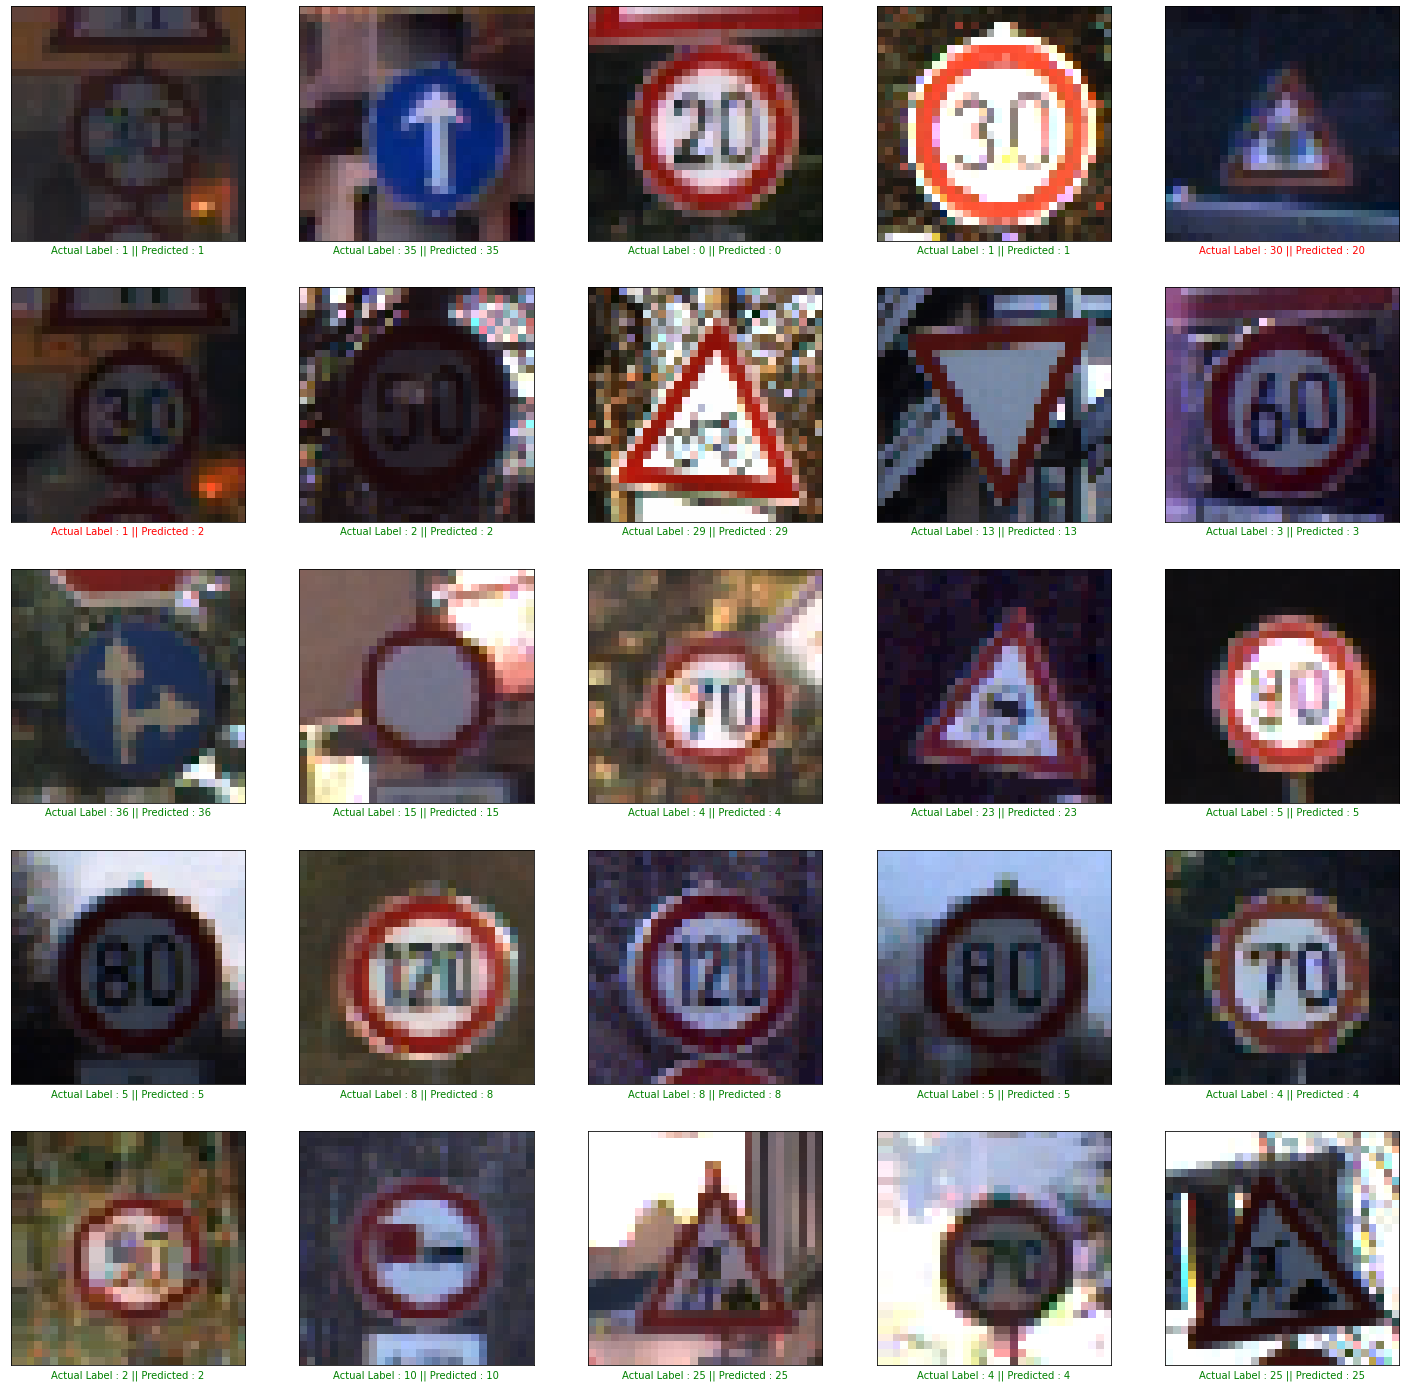

In [26]:
plt.figure(figsize = (25, 25))

start_index = 6000
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = predictions[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual Label : {} || Predicted : {}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()